In [1]:
import os
import random
import sys
sys.path.append("..")

import torch
import torch.nn.functional as F

import torchvision as tv

import cv2
import logging
import timm
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import proto
from src.configs.config import get_cfg
from src.data import loader as data_loadersetup
import src.utils.logging as logging
from train import setup, get_loaders

/home/yourenz/.conda/envs/proto/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yourenz/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yourenz/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model_root='/gpfs/accounts/eecs553w23_class_root/eecs553w23_class/shared_data/yourenz_group/pretrained/'
cfg_file = '../configs/prompt/cub.yaml'
cfg = get_cfg()
cfg.merge_from_file(cfg_file)
cfg.MODEL.MODEL_ROOT = model_root
cfg.DATA.FEATURE = 'sup_vitb16_imagenet21k'
cfg.NUM_GPUS = 1
cfg.SEED = 42
cfg.MODEL.PROMPT.NUM_TOKENS = 100

data_path='/gpfs/accounts/eecs598s010w23_class_root/eecs598s010w23_class/shared_data/yourenz_group/datasets/cub'
cfg.DATA.DATAPATH = data_path
logger = logging.get_logger("visual_prompt")

torch.manual_seed(cfg.SEED)
np.random.seed(cfg.SEED)
random.seed(0)

# Utils

In [3]:
def show_tensor_img(img):
    img = img.detach().cpu().permute(1, 2, 0)
    plt.imshow(img)
    
def idx_mapping(selected_idx_list, num_tokens=196):
    """
    selected_idx_list: a list of tensors, tensor: [B, L]
    return: 
    A list of slected_idx mapping back to image idx
    """
    B, _ = selected_idx_list[0].shape
    idx = torch.arange(num_tokens).expand(B, -1)
    mapping_idx = []

    for selected_idx in selected_idx_list:
        idx = torch.gather(idx, dim=1, index=selected_idx)
        mapping_idx.append(idx)

    return mapping_idx

def idx2xy(idx, num_patch=14):
    return idx // num_patch, idx % num_patch

def make_a_patch(img, idx, img_size=224, num_patch=14, color=(0.3, 0.3, 0.3)):
    pw = ph = img_size // num_patch
    if isinstance(idx, torch.Tensor):
        idx = idx.item()
    x, y = idx2xy(idx)
    
    start = (pw * x, ph * y)
    end = (pw * x + pw, ph * y + ph)
    new_img = cv2.rectangle(img, start, end, color, -1)
    return new_img

def make_patches(img, idxes):
    res_img = img.numpy()
    res_img = cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR)

    for idx in idxes:
        res_img = make_a_patch(res_img, idx)
    
    return cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)

def get_inverse_idx(idx, num_tokens=196):
    return set(torch.arange(num_tokens).tolist()) - set(idx.tolist())

# Data

In [4]:
from torch.utils.data import DataLoader
from src.data.datasets.json_dataset import JSONDataset

class CUB200Dataset(JSONDataset):
    """CUB_200 dataset."""

    def __init__(self, cfg, split, vis=False):
        super(CUB200Dataset, self).__init__(cfg, split)
        if vis:
            self.transform = tv.transforms.Compose(
                [
                    tv.transforms.Resize(256),
                    tv.transforms.CenterCrop(224),
                    tv.transforms.ToTensor(),
                ]
            )

    def get_imagedir(self):
        return os.path.join(self.data_dir, "images")
    
fw_ds = CUB200Dataset(cfg, "val", vis=False)
fw_dl = DataLoader(fw_ds, batch_size=32, shuffle=False)

vis_ds = CUB200Dataset(cfg, "val", vis=True)
vis_dl = DataLoader(vis_ds, batch_size=32, shuffle=False)

In [5]:
fw_batch, vis_batch = next(iter(fw_dl)), next(iter(vis_dl))
fw_imgs, labels = fw_batch["image"], fw_batch["label"]
vis_imgs = vis_batch["image"]

# Model

In [6]:
from src.models.build_model import build_model

model, cur_device = build_model(cfg)

In [7]:
import proto

cfg.K = 0.1
cfg.MODE = "max"

model.cuda()
proto.patch.vpt(model, K=cfg.K, mode=cfg.MODE, vis=True)
model.r = 13

print("the throughput is {} img/s".format(proto.utils.benchmark(model, device="cuda")))
print(model.num_tokens)

Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
Replace with ProtoBlock_v1
the throughput is 244.31821830717485 img/s
[284, 271, 258, 245, 232, 219, 206, 193, 180, 167, 154, 141]


In [8]:
ckpt_path = '/home/yourenz/SynergisticEfficiency/exps/proto_model.pth'
model.load_state_dict(torch.load(ckpt_path)['model'])

<All keys matched successfully>

# Forward

In [9]:
model.eval()
fw_imgs = fw_imgs.cuda()
labels = labels.cuda()
output = model(fw_imgs)

# select pred is corret
pred = output.argmax(axis=-1)

In [10]:
labels == pred

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False, False], device='cuda:0')

# Vis

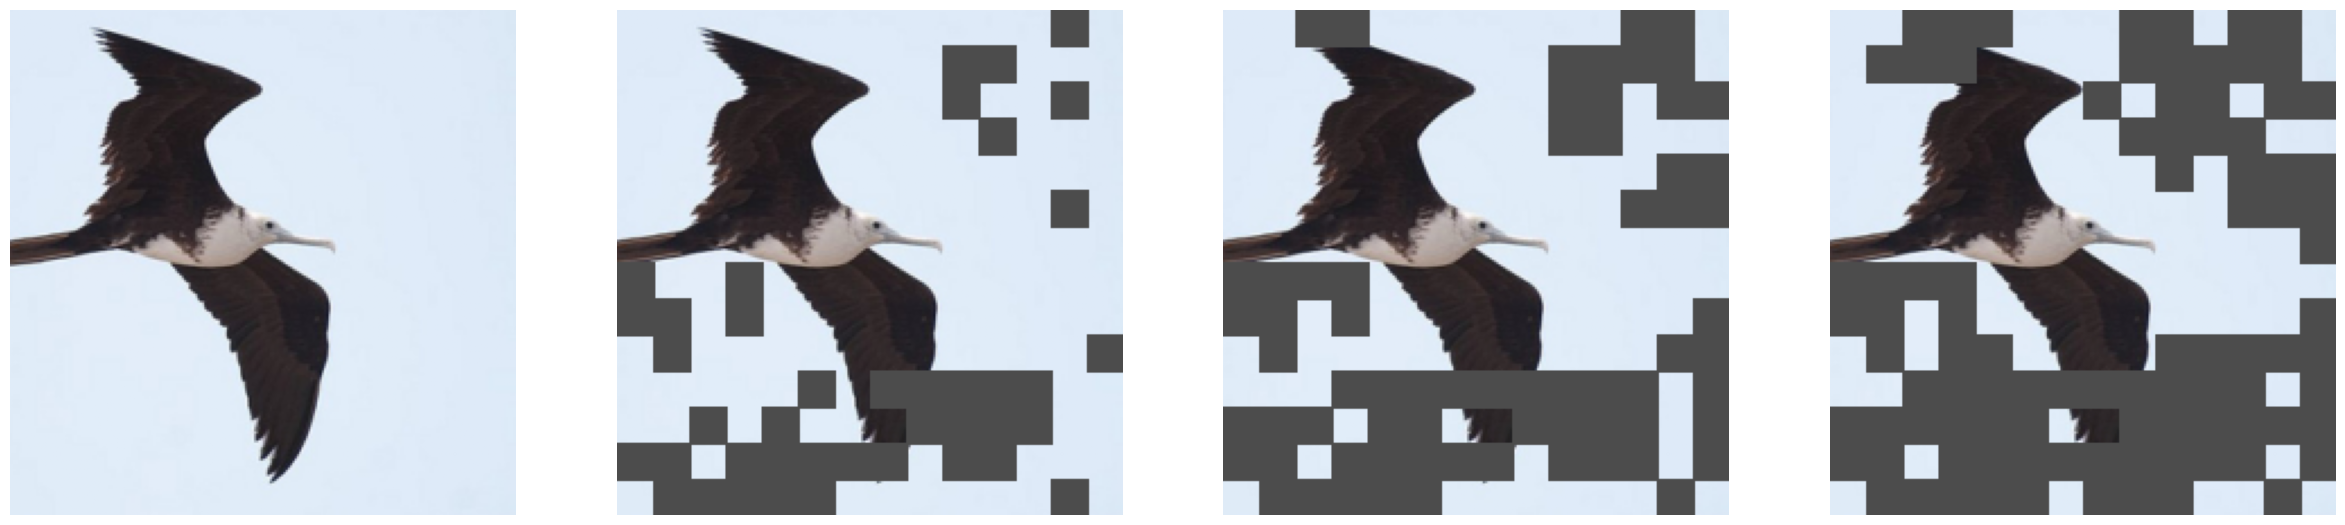

In [22]:
img_idx = 8
num_tokens = 100 + 196

img = vis_imgs[img_idx].detach().cpu().permute(1, 2, 0)

mapping_idx = idx_mapping(model.idx_tracker, num_tokens=num_tokens)

# Select non-prompt idx
all_layer_idx = [layer_idx[img_idx] for layer_idx in mapping_idx]
img_tokens_idx = [layer_idx[layer_idx >= 100] - 100 for layer_idx in all_layer_idx]

all_reducted_idx = [get_inverse_idx(idx, num_tokens=num_tokens) for idx in img_tokens_idx]

all_reducted_idx = [all_reducted_idx[i] for i in [4, 7, 10]]

f, axes = plt.subplots(1, 1 + len(all_reducted_idx), figsize=(30, 10))
axes[0].imshow(img)
axes[0].axis(False)

for layer_idx, (idxes, ax) in enumerate(zip(all_reducted_idx, axes.ravel()[1:])):
    ax.imshow(make_patches(img, idxes))
    ax.axis(False)
    # ax.set_title(f"Layer {layer_idx}")